In [69]:
from __future__ import print_function, division
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import mnist
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [70]:
#Creating Generator for CGANS
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])#concatenating (100,) tensor with (10,1) tensor
  hid = Dense(128 * 7 * 7, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((7, 7, 128))(hid)
  hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)        
  hid = Conv2D(1, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)
  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  return model, out

In [71]:
#Creating Discriminator for CGANS
def get_discriminator(input_layer, condition_layer):
    
  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Flatten()(hid)
  merged_layer = Concatenate()([hid, condition_layer])
  hid = Dense(512, activation='relu')(merged_layer)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)
  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  return model, out

In [72]:
from keras.preprocessing import image

#making one_hot_encoder function to get encoders
def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

#function to make a latent space vector
def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

#function to return one hot encoders corresponding to labels
def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y

tags = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
 
#function to generate/print images from generator
def show_samples(batchidx):
  fig, axs = plt.subplots(5, 6, figsize=(10,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
    
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * 3)
    noise = generate_noise(3, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
          axs[row,i+coloffset].set_title(tags[classlabel])
  plt.show()
  plt.close()

In [73]:
#Creating tensors for input images and labels(next 2 lines)
img_input = Input(shape=(28,28,1))
disc_condition_input = Input(shape=(10,))
discriminator, disc_out = get_discriminator(img_input, disc_condition_input)  #'discrminator' will store the model. From now on, we will just need 'dicriminator' from this line for further compilations and classification of fake and real images
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])       #||
discriminator.trainable = False                                                                            #||
noise_input = Input(shape=(100,))    #creating tensor                                                                      #||
gen_condition_input = Input(shape=(10,)) #creating tensor                                                                  #\/
generator, gen_out = get_generator(noise_input, gen_condition_input)#------------------------------------> Same thing for 'generator' in this line
gan_input = Input(shape=(100,))#creating tensor
x = generator([gan_input, gen_condition_input])#feeding random noise/latent space vector and label in 'generator'
gan_out = discriminator([x, disc_condition_input])#whatever comes out of generator after executing the previous line is fed into discriminator along with the labels
gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)#Feeding the above found values into the GAN for both discriminator and generator weights to learn
gan.summary()
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 128)  1280        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 28, 28, 128)  512         conv2d_19[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 28, 28, 128)  0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_20 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 28, 28, 1)    2743553     input_20[0][0]                   
                                                                 input_19[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 10)           0                                            
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  del sys.path[0]


In [74]:
#creating batchsize, importing dataset from keras library, converting target labels to one hot encoded labels
BATCH_SIZE = 100
(X_train, y_train), (X_test, _) = mnist.load_data()
X_train = (X_train - 127.5) / 127.5
y_train = one_hot_encode(y_train[:])
print ("Training shape: {}".format(X_train.shape))
num_batches = int(X_train.shape[0]/BATCH_SIZE) # number of batches is number of training examples (as given by X_train.shape[0]) divided by batchsize

Training shape: (60000, 28, 28)


In [75]:
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [76]:
y_train.shape

(60000, 10)

In [77]:
x=X_train
x = x.reshape((60000, 28, 28, 1))


In [78]:
x.shape

(60000, 28, 28, 1)

In [79]:
X_train=x

In [80]:
#Creating an array to store images for experience replay
exp_replay = []

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


	Epoch: 1, Generator Loss: 0.22992134476701417, Discriminator Loss: [0.07019549 0.        ]


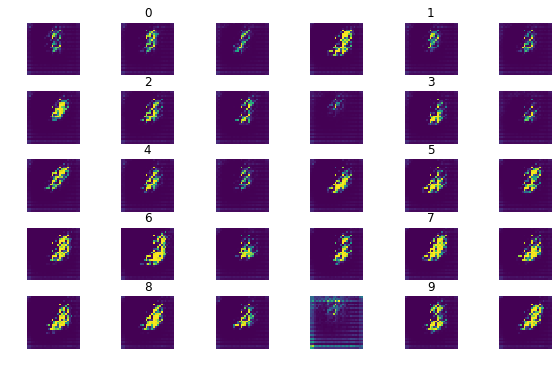

	Epoch: 2, Generator Loss: 0.20578154418617486, Discriminator Loss: [0.05923799 0.        ]


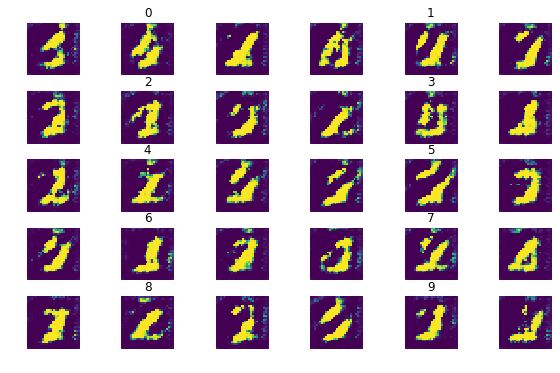

	Epoch: 3, Generator Loss: 0.27696214720606804, Discriminator Loss: [0.08420394 0.        ]


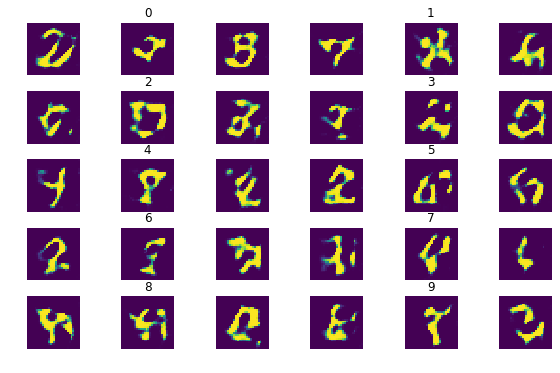

	Epoch: 4, Generator Loss: 0.2696161295970281, Discriminator Loss: [0.09056199 0.        ]


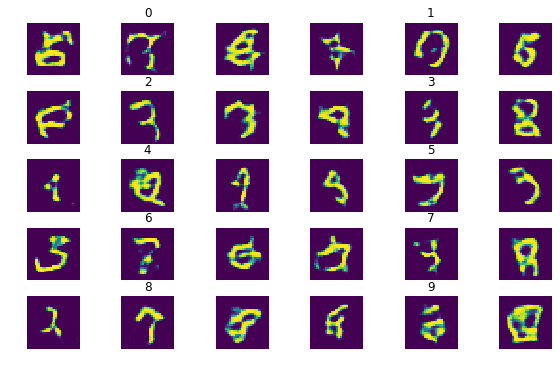

	Epoch: 5, Generator Loss: 0.27300224860509237, Discriminator Loss: [0.08811021 0.        ]


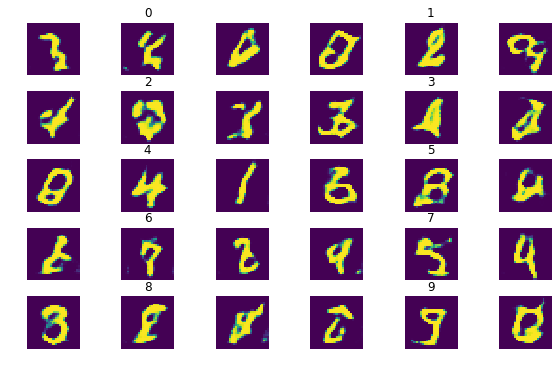

	Epoch: 6, Generator Loss: 0.291251500248909, Discriminator Loss: [0.08516058 0.        ]


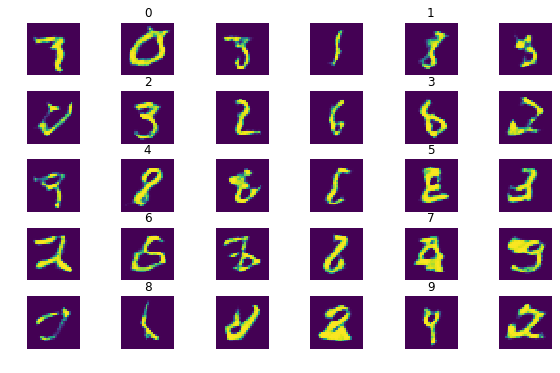

	Epoch: 7, Generator Loss: 0.29339092632134756, Discriminator Loss: [0.08555106 0.        ]


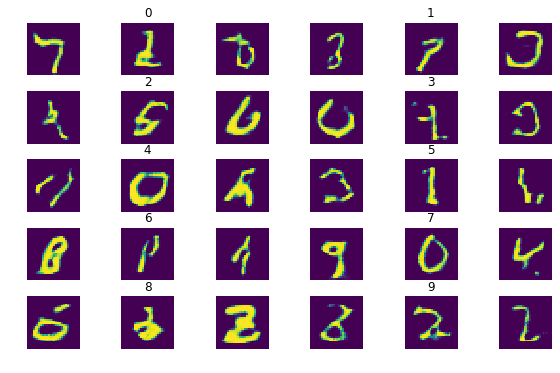

	Epoch: 8, Generator Loss: 0.28646816849708556, Discriminator Loss: [0.08495203 0.        ]


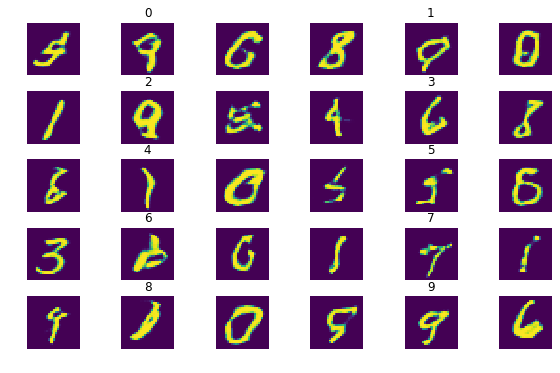

	Epoch: 9, Generator Loss: 0.28477982958157855, Discriminator Loss: [0.08572273 0.        ]


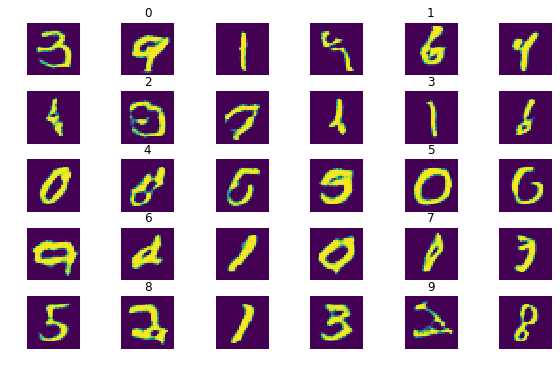

	Epoch: 10, Generator Loss: 0.2881690502166748, Discriminator Loss: [8.482195e-02 8.333333e-06]


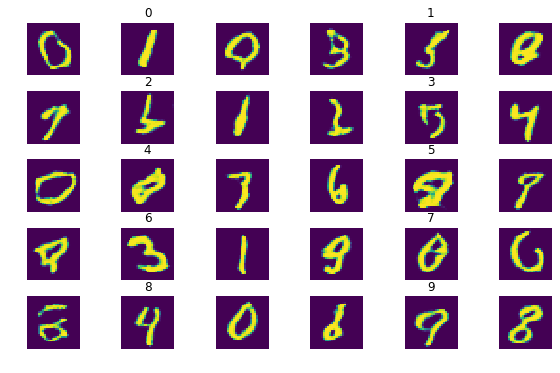

	Epoch: 11, Generator Loss: 0.291745653351148, Discriminator Loss: [0.08317446 0.        ]


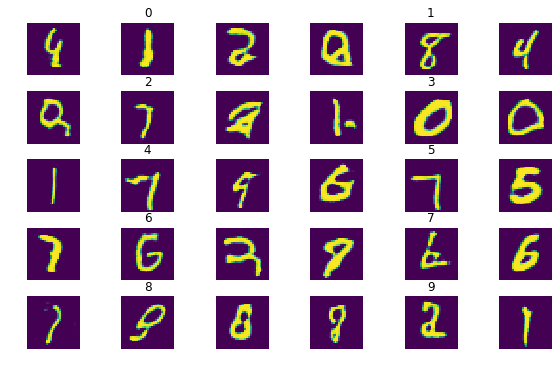

	Epoch: 12, Generator Loss: 0.28665670613447825, Discriminator Loss: [0.08336789 0.        ]


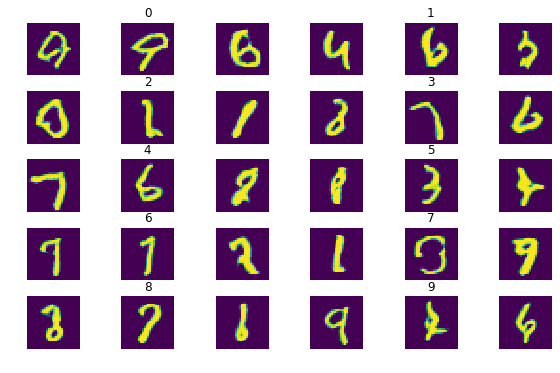

	Epoch: 13, Generator Loss: 0.2995429021120071, Discriminator Loss: [0.08167639 0.        ]


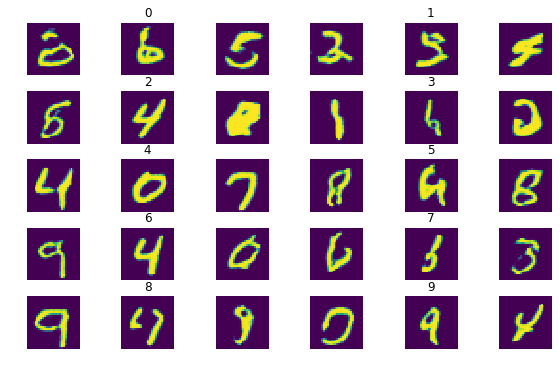

	Epoch: 14, Generator Loss: 0.29123479227224985, Discriminator Loss: [0.08185332 0.        ]


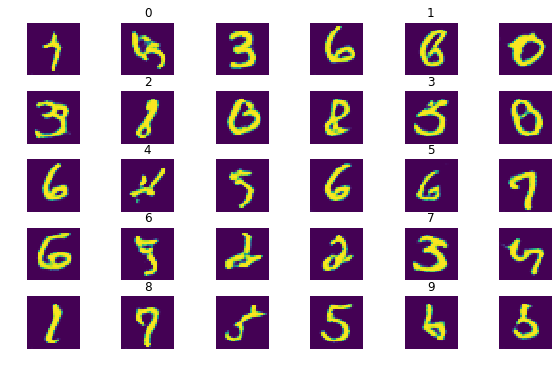

	Epoch: 15, Generator Loss: 0.2945053728421529, Discriminator Loss: [0.08258493 0.        ]


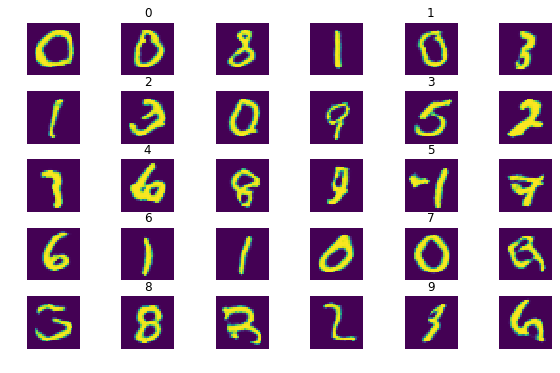

	Epoch: 16, Generator Loss: 0.29553966561953227, Discriminator Loss: [0.08106212 0.        ]


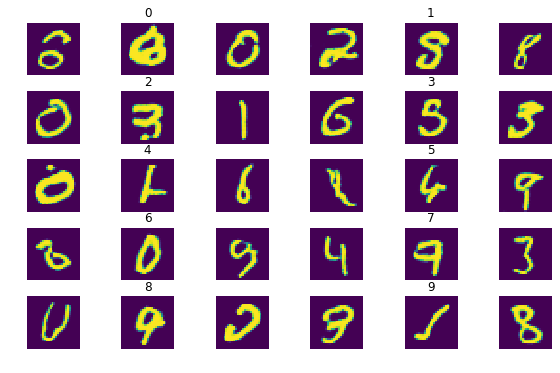

	Epoch: 17, Generator Loss: 0.2960707849264145, Discriminator Loss: [0.08075637 0.        ]


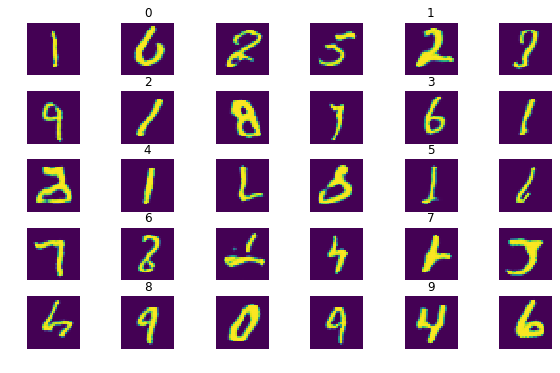

	Epoch: 18, Generator Loss: 0.29920169393221535, Discriminator Loss: [0.08008557 0.        ]


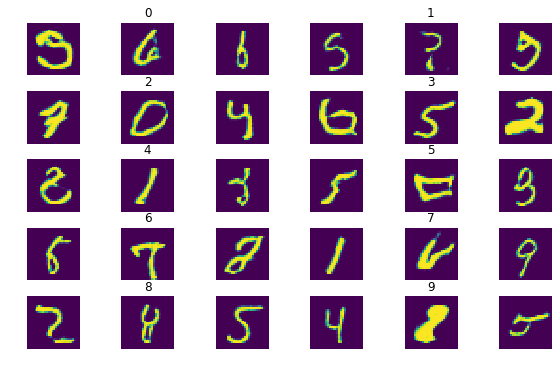

	Epoch: 19, Generator Loss: 0.29658239404360454, Discriminator Loss: [0.08063634 0.        ]


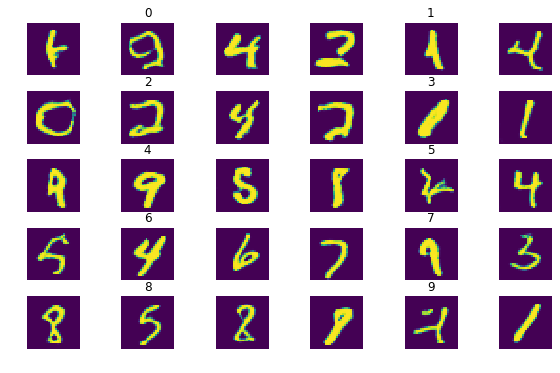

	Epoch: 20, Generator Loss: 0.302996852795283, Discriminator Loss: [0.0799358 0.       ]


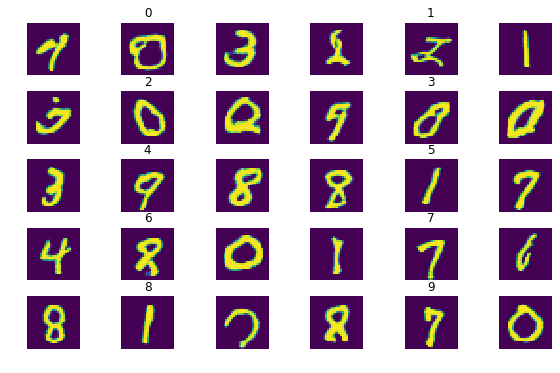

	Epoch: 21, Generator Loss: 0.3052194792032242, Discriminator Loss: [0.07890144 0.        ]


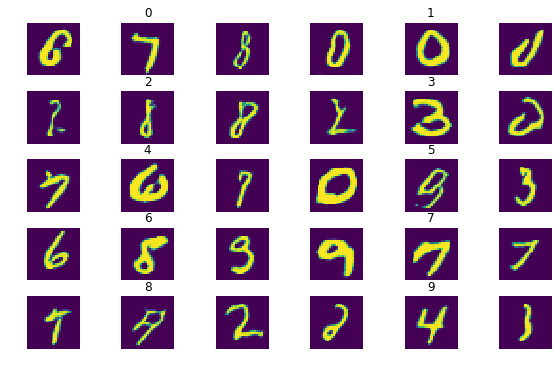

	Epoch: 22, Generator Loss: 0.3073196828365326, Discriminator Loss: [0.07881839 0.        ]


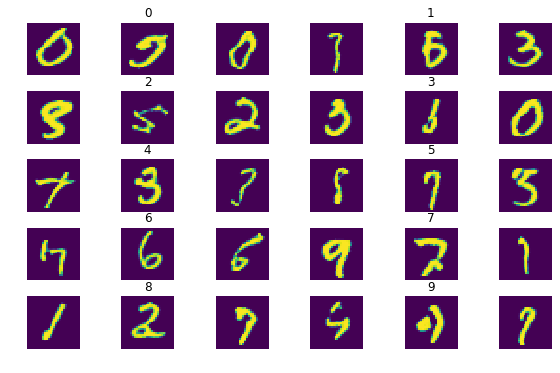

	Epoch: 23, Generator Loss: 0.3166146594285965, Discriminator Loss: [0.07828601 0.        ]


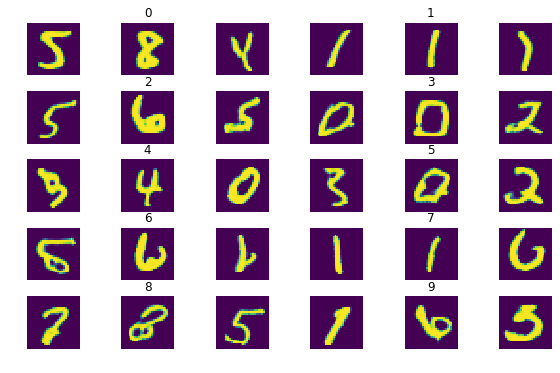

	Epoch: 24, Generator Loss: 0.3088720597823461, Discriminator Loss: [0.07901026 0.        ]


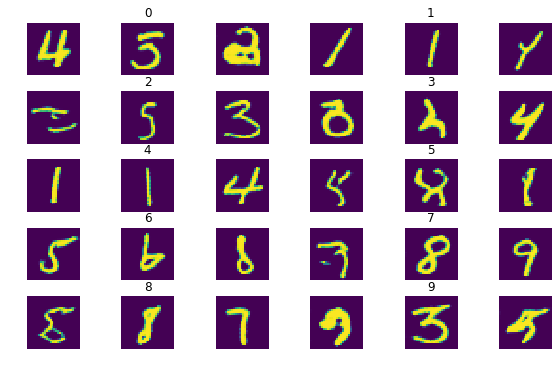

	Epoch: 25, Generator Loss: 0.31567000726858774, Discriminator Loss: [0.07763033 0.        ]


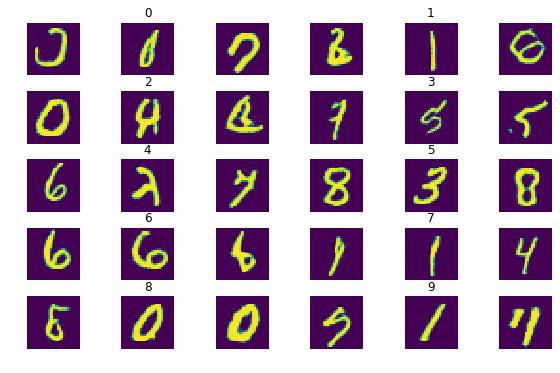

	Epoch: 26, Generator Loss: 0.311558007200559, Discriminator Loss: [0.07815635 0.        ]


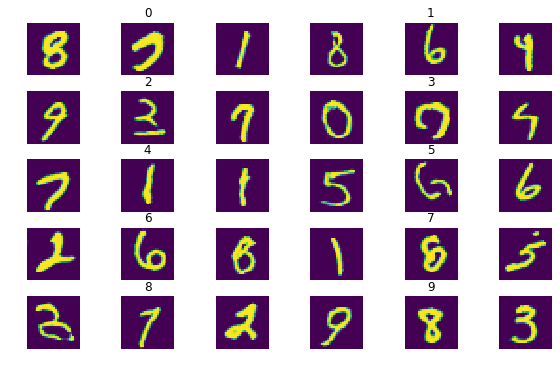

	Epoch: 27, Generator Loss: 0.31503173251946764, Discriminator Loss: [0.07806868 0.        ]


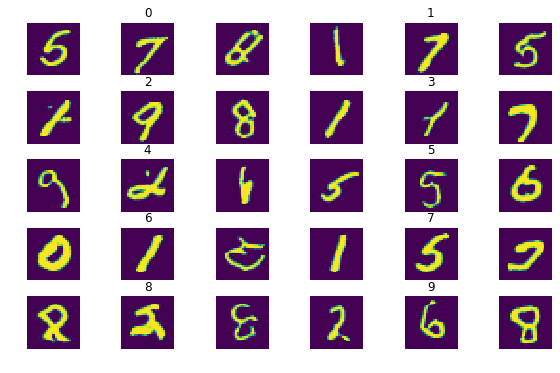

	Epoch: 28, Generator Loss: 0.32133751650651293, Discriminator Loss: [0.07736622 0.        ]


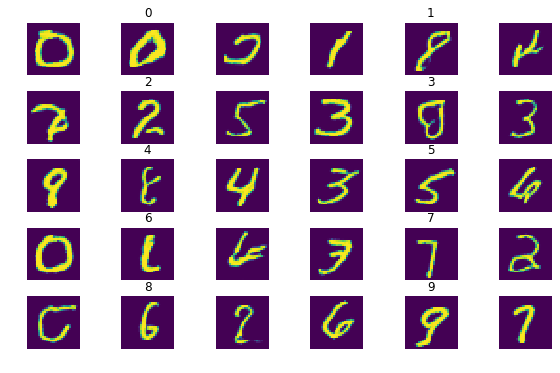

	Epoch: 29, Generator Loss: 0.3256886500120163, Discriminator Loss: [0.07714575 0.        ]


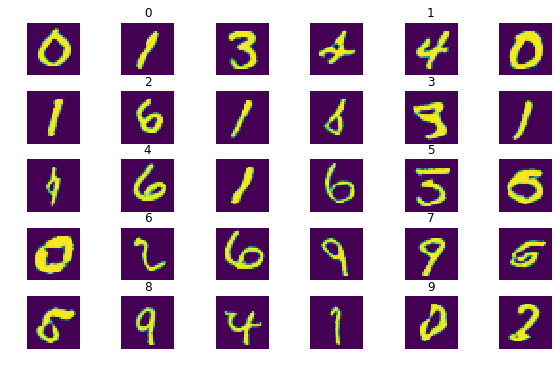

	Epoch: 30, Generator Loss: 0.31890353083610534, Discriminator Loss: [0.07748231 0.        ]


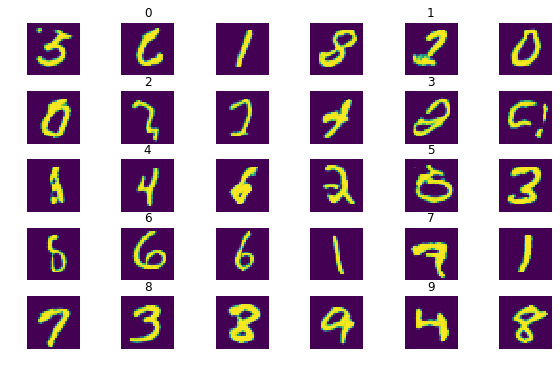

	Epoch: 31, Generator Loss: 0.3242576982577642, Discriminator Loss: [0.07705317 0.        ]


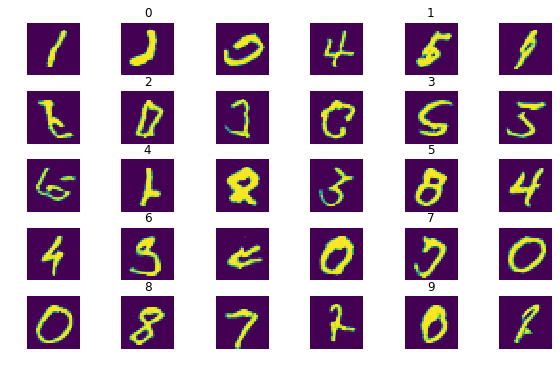

	Epoch: 32, Generator Loss: 0.32849294583002725, Discriminator Loss: [0.07763453 0.        ]


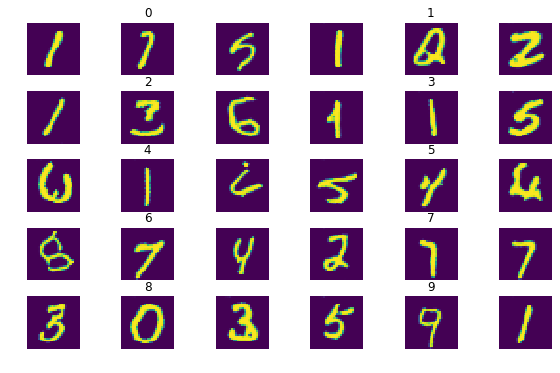

	Epoch: 33, Generator Loss: 0.3225749933719635, Discriminator Loss: [0.07761304 0.        ]


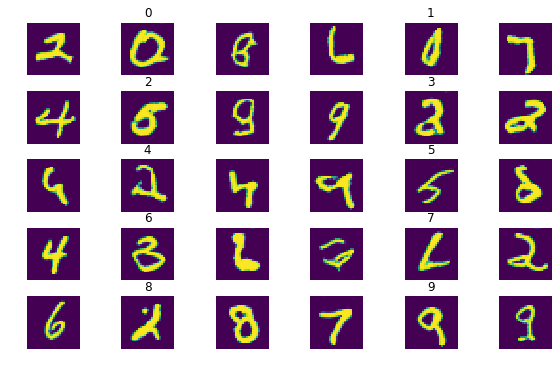

	Epoch: 34, Generator Loss: 0.31944205323855085, Discriminator Loss: [0.07738724 0.        ]


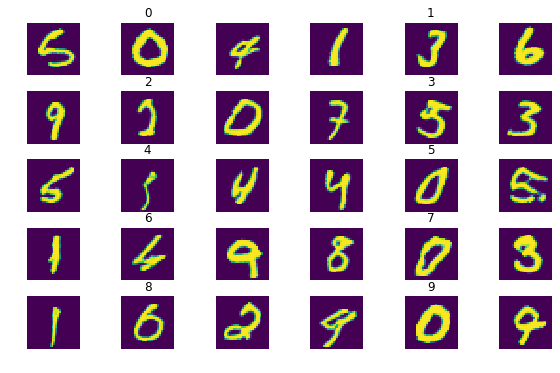

	Epoch: 35, Generator Loss: 0.3204963453610738, Discriminator Loss: [0.07755429 0.        ]


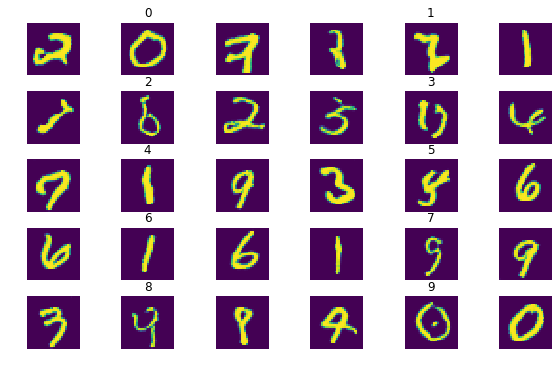

	Epoch: 36, Generator Loss: 0.3289607230822245, Discriminator Loss: [0.07798781 0.        ]


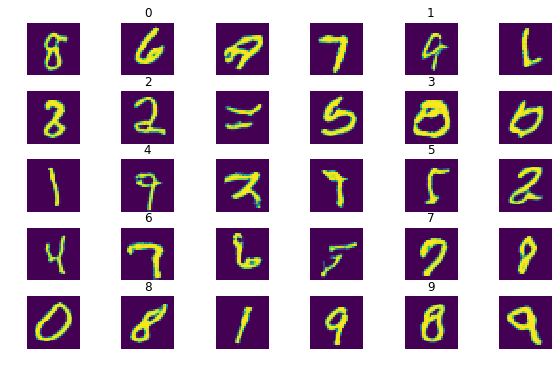

	Epoch: 37, Generator Loss: 0.3157540669043859, Discriminator Loss: [0.07896428 0.        ]


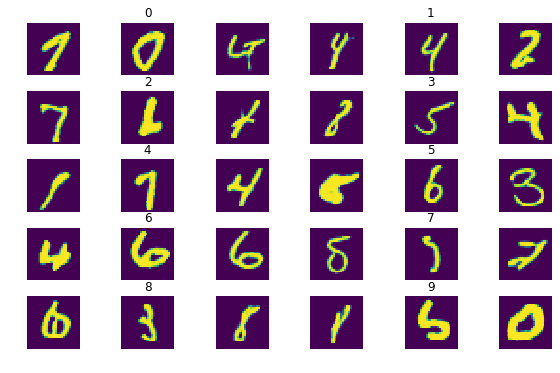

	Epoch: 38, Generator Loss: 0.31978363732496895, Discriminator Loss: [0.07796207 0.        ]


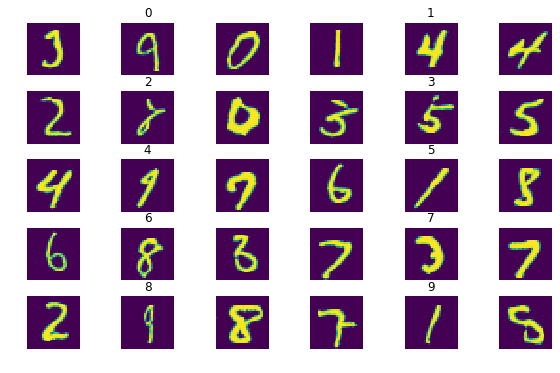

	Epoch: 39, Generator Loss: 0.32331615388393403, Discriminator Loss: [0.07831775 0.        ]


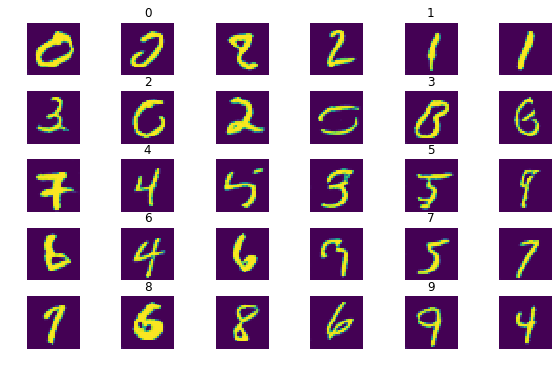

	Epoch: 40, Generator Loss: 0.3190827564398448, Discriminator Loss: [0.0797913 0.       ]


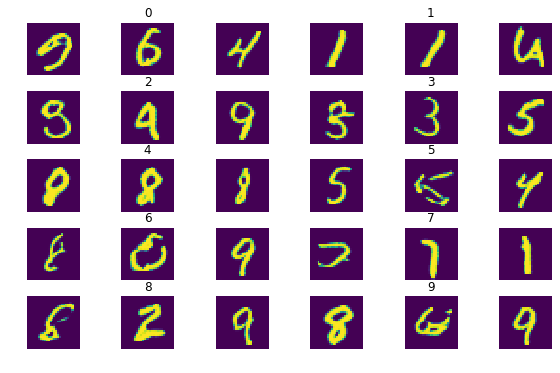

	Epoch: 41, Generator Loss: 0.32240330119927724, Discriminator Loss: [0.07983585 0.        ]


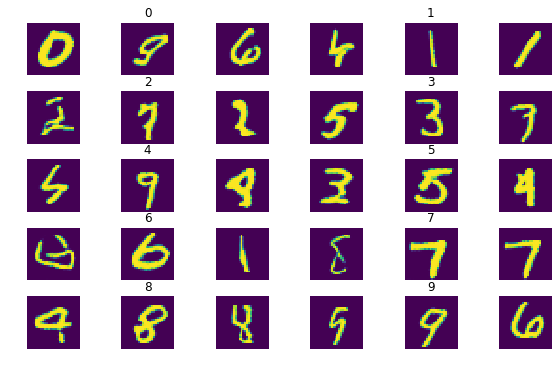

	Epoch: 42, Generator Loss: 0.3192528853813807, Discriminator Loss: [0.07891625 0.        ]


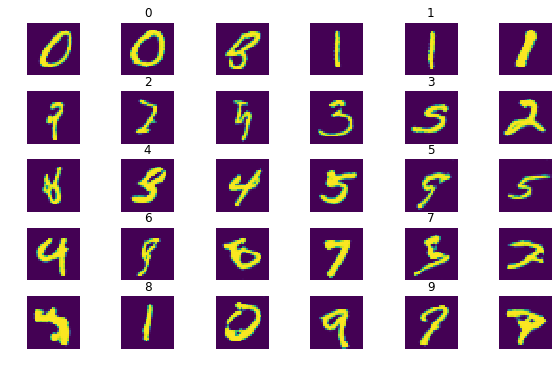

	Epoch: 43, Generator Loss: 0.3269324427843094, Discriminator Loss: [0.08013999 0.        ]


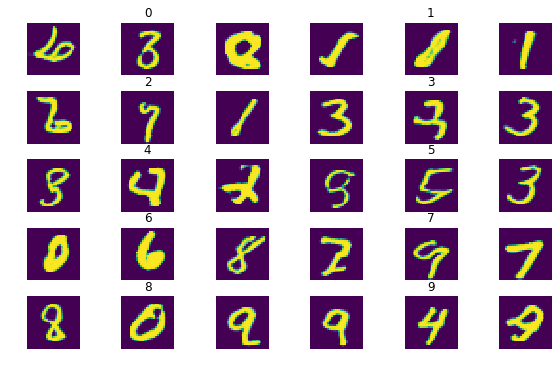

	Epoch: 44, Generator Loss: 0.3141314349571864, Discriminator Loss: [0.07999739 0.        ]


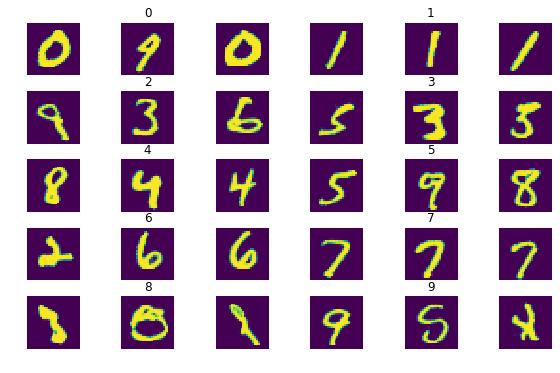

	Epoch: 45, Generator Loss: 0.3220793475707372, Discriminator Loss: [0.07997981 0.        ]


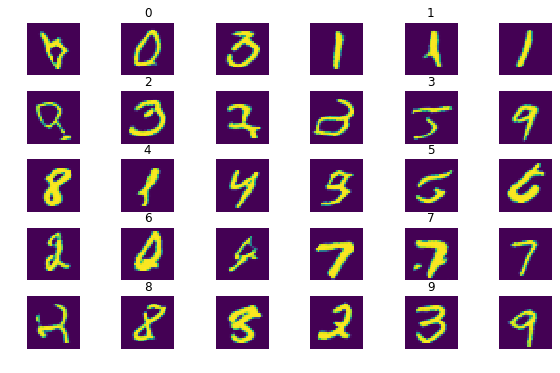

	Epoch: 46, Generator Loss: 0.27842509528001147, Discriminator Loss: [0.08749568 0.        ]


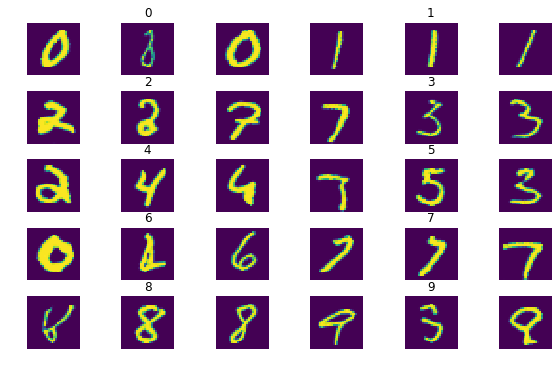

	Epoch: 47, Generator Loss: 0.3008214457829793, Discriminator Loss: [0.08336603 0.        ]


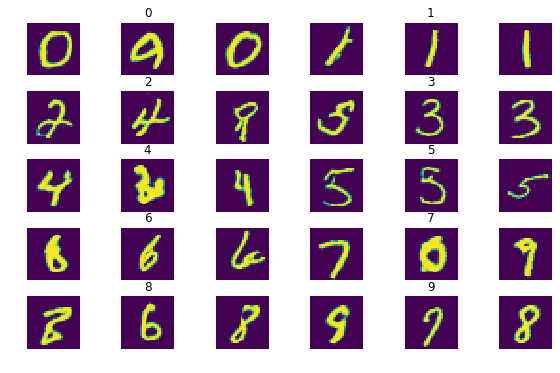

	Epoch: 48, Generator Loss: 0.3042962116003036, Discriminator Loss: [0.08361416 0.        ]


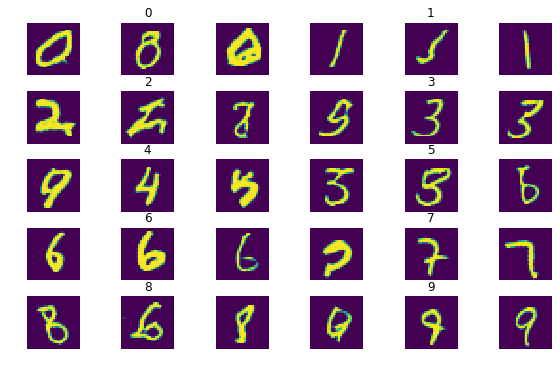

	Epoch: 49, Generator Loss: 0.3048249097665151, Discriminator Loss: [0.08408507 0.        ]


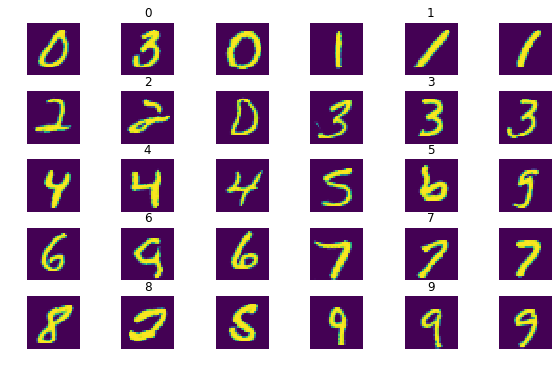

	Epoch: 50, Generator Loss: 0.30487213750680286, Discriminator Loss: [8.4012784e-02 8.3333334e-06]


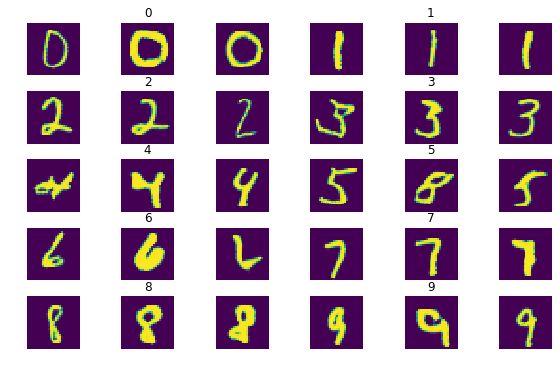

	Epoch: 51, Generator Loss: 0.29279478788375857, Discriminator Loss: [0.08425611 0.        ]


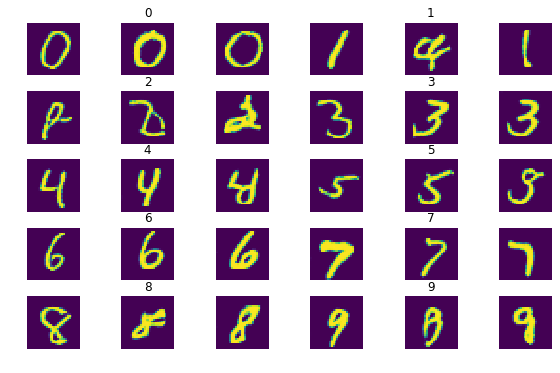

	Epoch: 52, Generator Loss: 0.30270460188388826, Discriminator Loss: [0.08498438 0.        ]


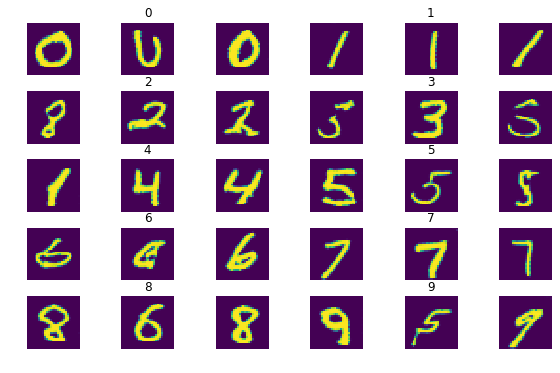

	Epoch: 53, Generator Loss: 0.29191959122816724, Discriminator Loss: [0.08536759 0.        ]


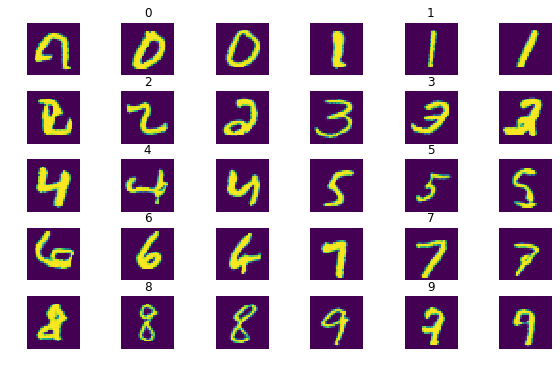

	Epoch: 54, Generator Loss: 0.2941805406411489, Discriminator Loss: [0.0852863 0.       ]


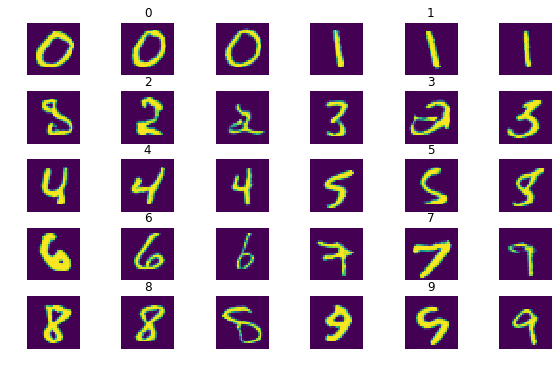

	Epoch: 55, Generator Loss: 0.2955560747782389, Discriminator Loss: [0.08543329 0.        ]


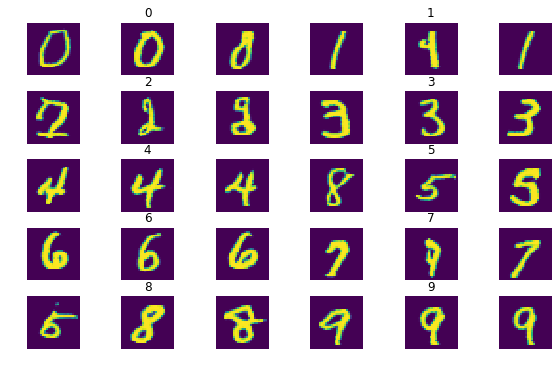

	Epoch: 56, Generator Loss: 0.29362176815668745, Discriminator Loss: [0.08465137 0.        ]


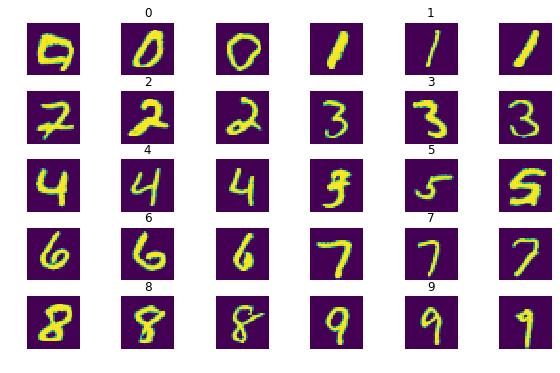

	Epoch: 57, Generator Loss: 0.28843215266863503, Discriminator Loss: [0.08480233 0.        ]


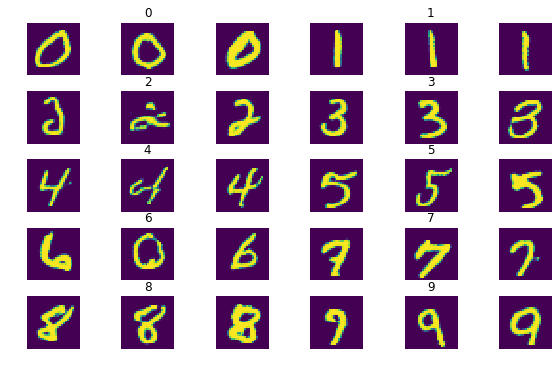

	Epoch: 58, Generator Loss: 0.29931863129138947, Discriminator Loss: [0.08301841 0.        ]


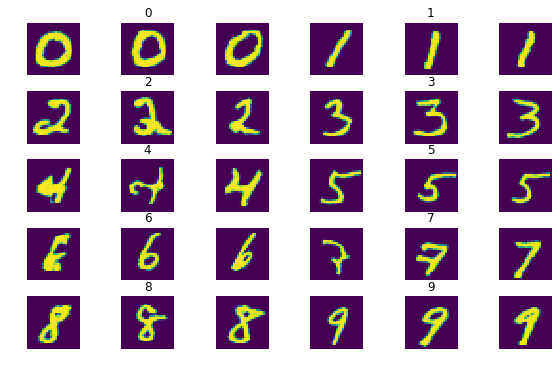

	Epoch: 59, Generator Loss: 0.29882963597774503, Discriminator Loss: [0.08402159 0.        ]


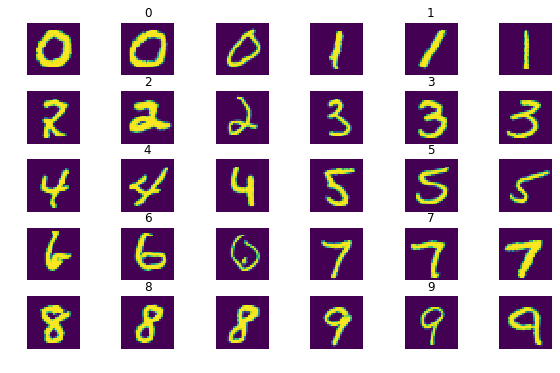

	Epoch: 60, Generator Loss: 0.30819244881471, Discriminator Loss: [0.08253191 0.        ]


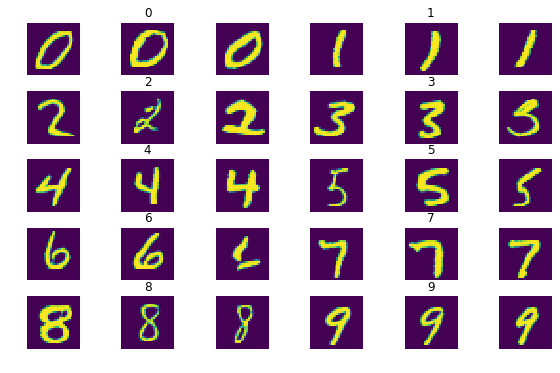

	Epoch: 61, Generator Loss: 0.30787118315696715, Discriminator Loss: [0.08175419 0.        ]


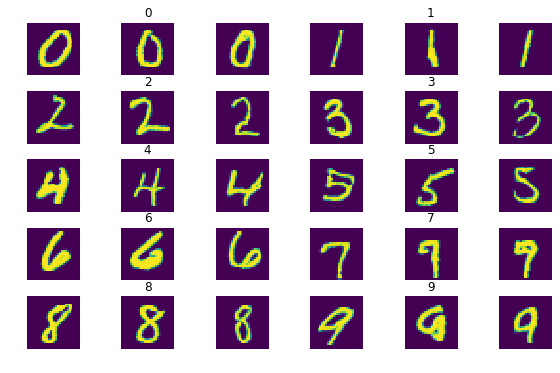

	Epoch: 62, Generator Loss: 0.3113785550991694, Discriminator Loss: [0.08134924 0.        ]


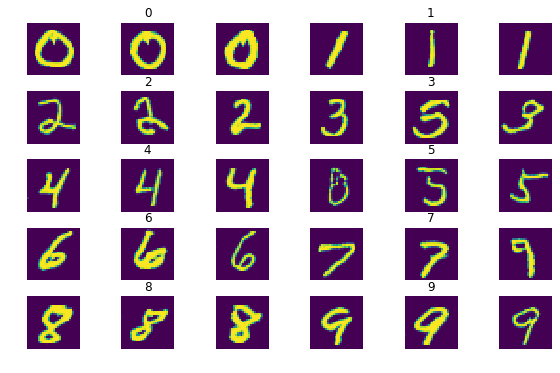

	Epoch: 63, Generator Loss: 0.31610373000303904, Discriminator Loss: [0.0811744 0.       ]


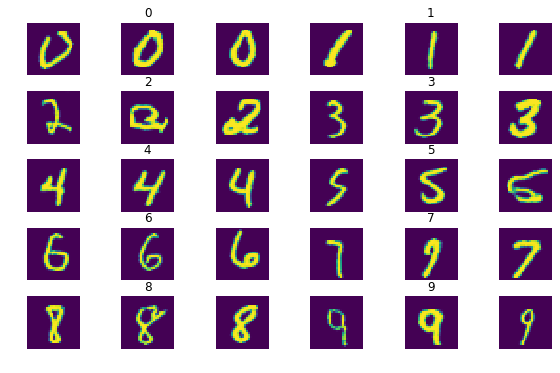

	Epoch: 64, Generator Loss: 0.3116582230726878, Discriminator Loss: [0.0823819 0.       ]


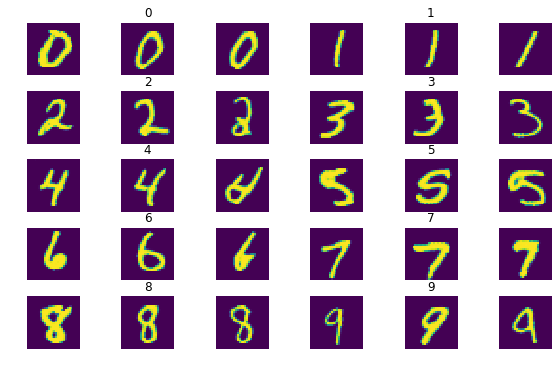

	Epoch: 65, Generator Loss: 0.32082139790058134, Discriminator Loss: [0.07982425 0.        ]


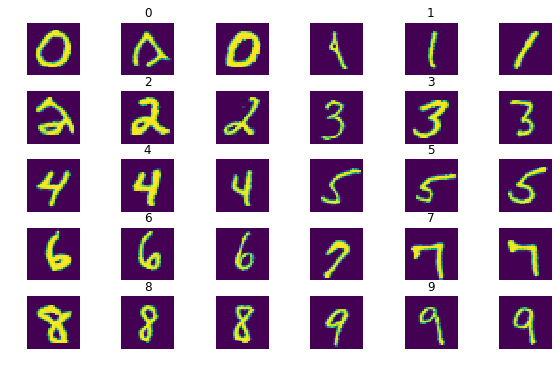

	Epoch: 66, Generator Loss: 0.32481507341066995, Discriminator Loss: [0.07918599 0.        ]


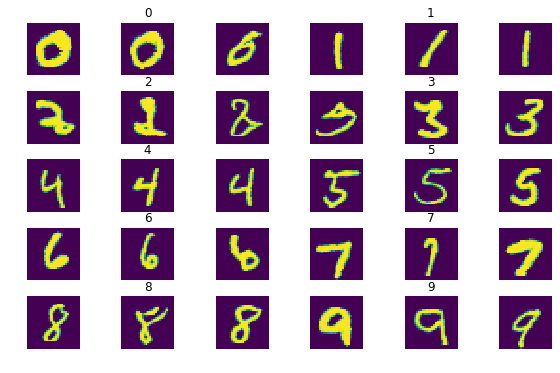

	Epoch: 67, Generator Loss: 0.31981324950853984, Discriminator Loss: [0.07882173 0.        ]


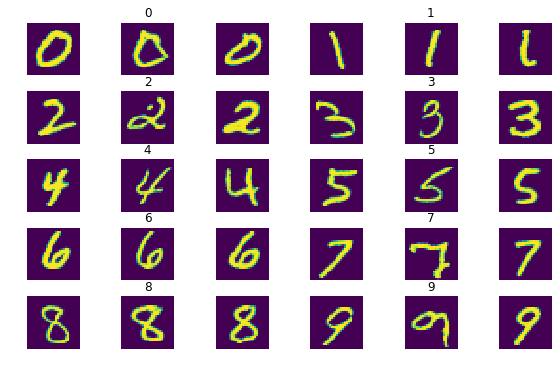

	Epoch: 68, Generator Loss: 0.3314710479974747, Discriminator Loss: [0.07812424 0.        ]


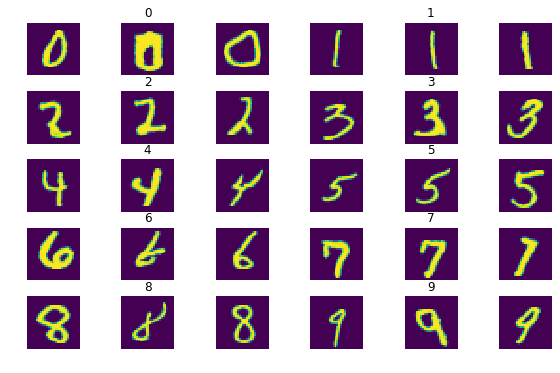

	Epoch: 69, Generator Loss: 0.33736251095930736, Discriminator Loss: [0.07751413 0.        ]


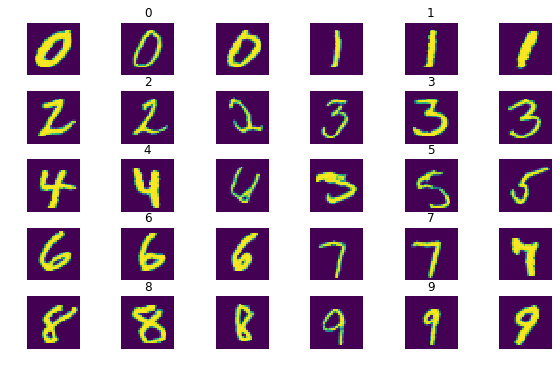

	Epoch: 70, Generator Loss: 0.3373506263891856, Discriminator Loss: [0.07723386 0.        ]


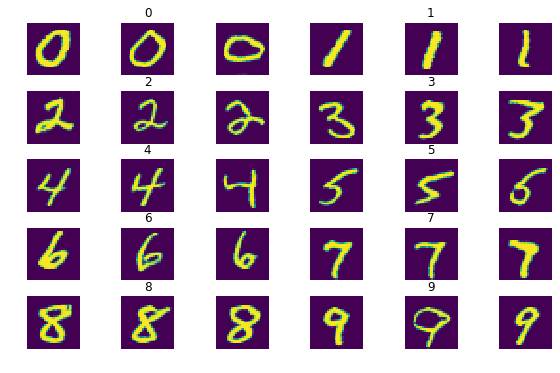

	Epoch: 71, Generator Loss: 0.334399292866389, Discriminator Loss: [0.07823172 0.        ]


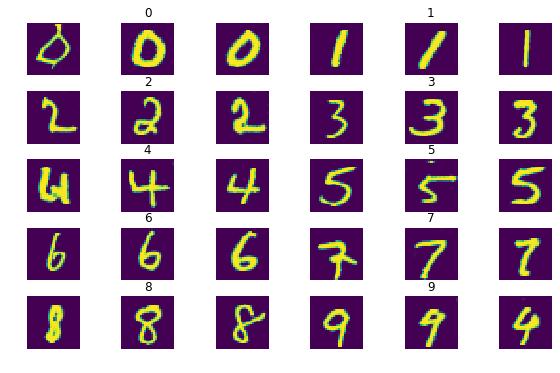

	Epoch: 72, Generator Loss: 0.3377920405069987, Discriminator Loss: [0.07679623 0.        ]


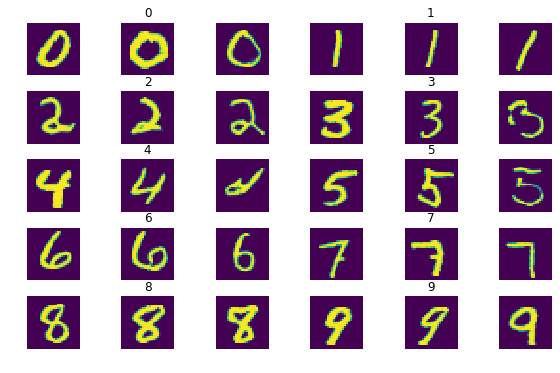

	Epoch: 73, Generator Loss: 0.3387753266096115, Discriminator Loss: [0.07644889 0.        ]


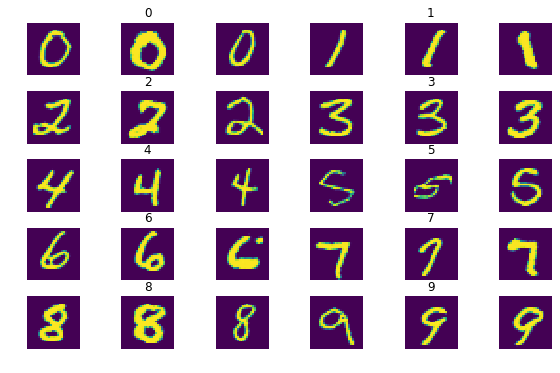

	Epoch: 74, Generator Loss: 0.342339243888855, Discriminator Loss: [0.07638113 0.        ]


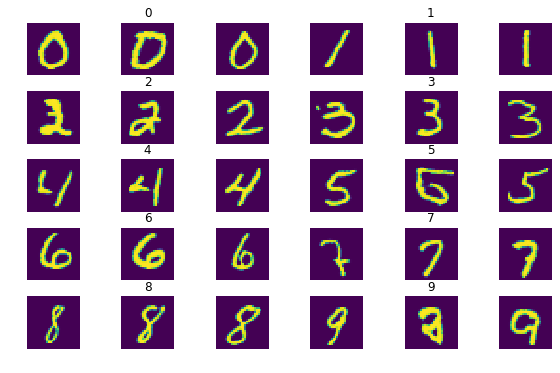

	Epoch: 75, Generator Loss: 0.3394464067618052, Discriminator Loss: [0.07679797 0.        ]


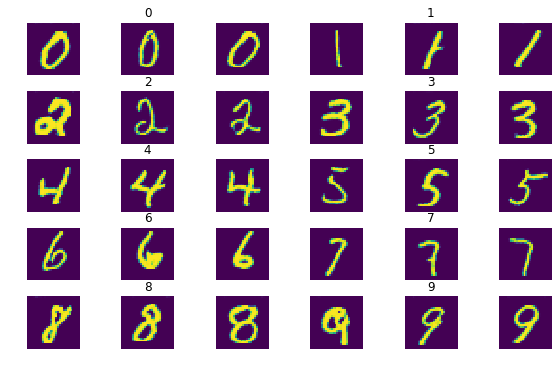

	Epoch: 76, Generator Loss: 0.3470609893401464, Discriminator Loss: [0.07492956 0.        ]


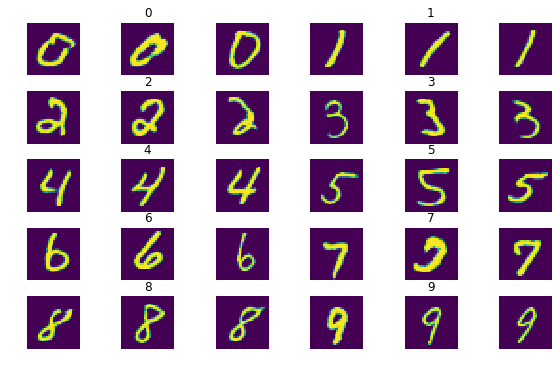

	Epoch: 77, Generator Loss: 0.3440902425845464, Discriminator Loss: [0.07605705 0.        ]


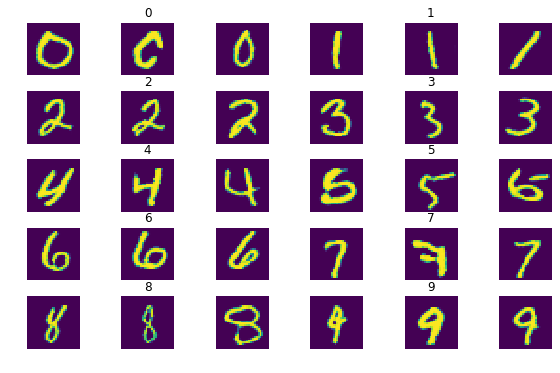

	Epoch: 78, Generator Loss: 0.3582276276747386, Discriminator Loss: [0.07381213 0.        ]


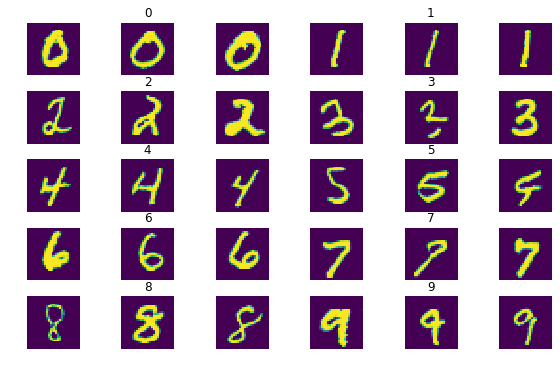

	Epoch: 79, Generator Loss: 0.35570193926493326, Discriminator Loss: [0.07330026 0.        ]


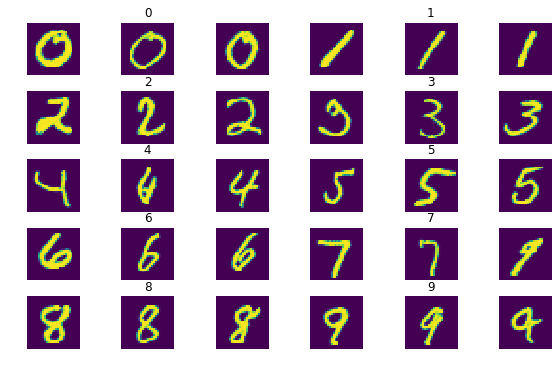

	Epoch: 80, Generator Loss: 0.3588567558924357, Discriminator Loss: [0.07356165 0.        ]


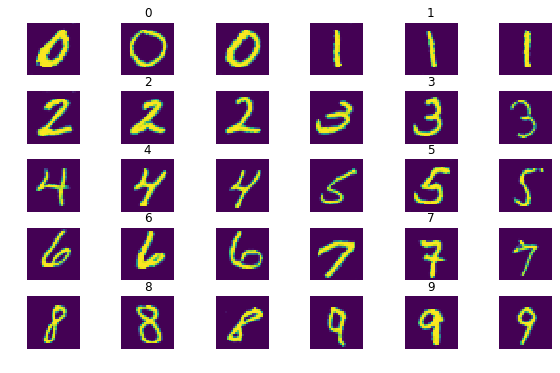

	Epoch: 81, Generator Loss: 0.36033907254536945, Discriminator Loss: [0.07399131 0.        ]


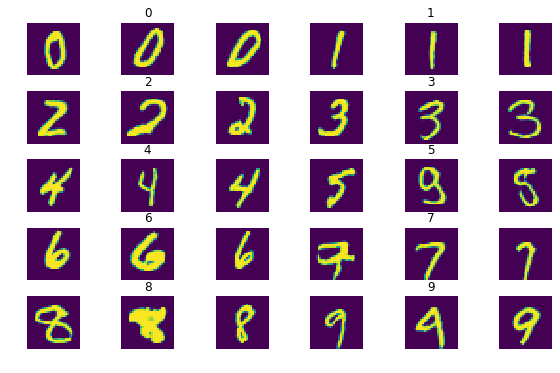

	Epoch: 82, Generator Loss: 0.3620499050617218, Discriminator Loss: [0.07366908 0.        ]


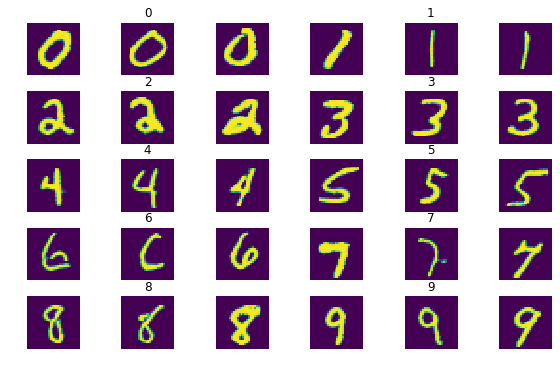

	Epoch: 83, Generator Loss: 0.365586646993955, Discriminator Loss: [0.07461455 0.        ]


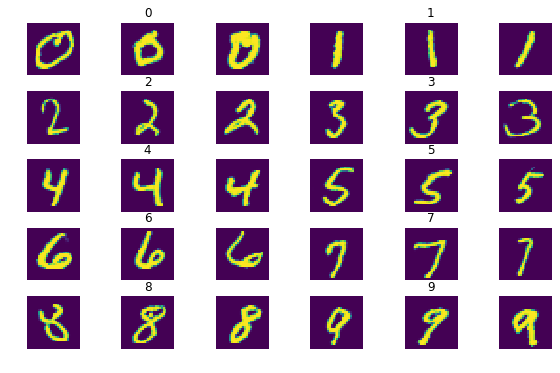

	Epoch: 84, Generator Loss: 0.3607432427008947, Discriminator Loss: [0.07350536 0.        ]


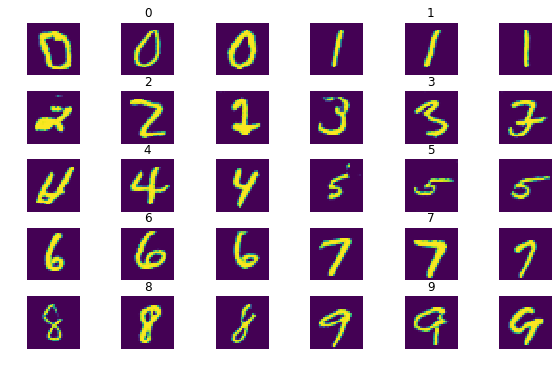

	Epoch: 85, Generator Loss: 0.3587356839577357, Discriminator Loss: [0.07251031 0.        ]


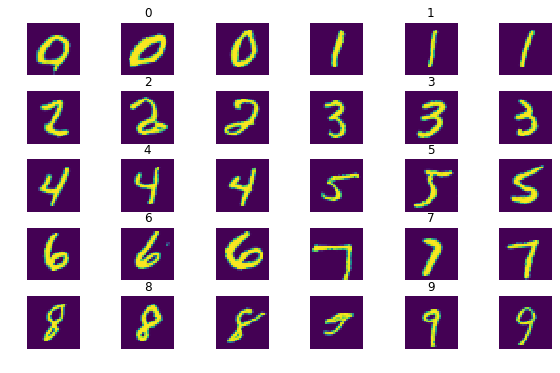

	Epoch: 86, Generator Loss: 0.362385332385699, Discriminator Loss: [0.07338443 0.        ]


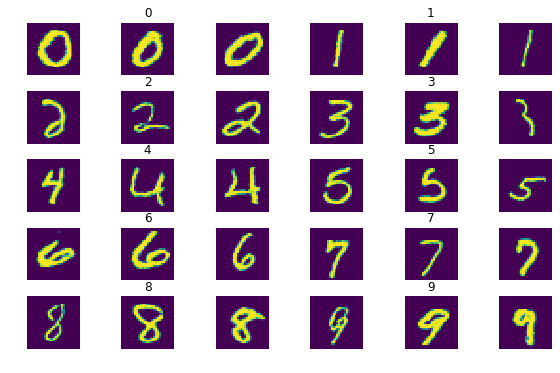

	Epoch: 87, Generator Loss: 0.36074307799339295, Discriminator Loss: [0.07328334 0.        ]


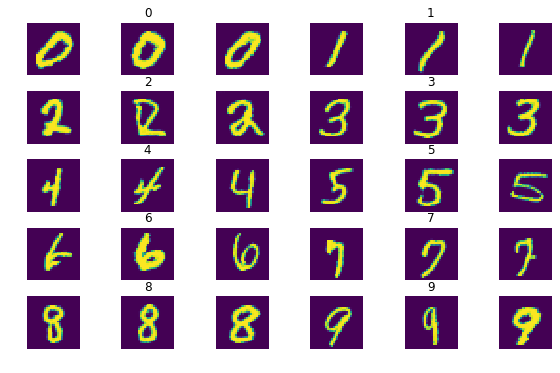

	Epoch: 88, Generator Loss: 0.370995999177297, Discriminator Loss: [0.07094442 0.        ]


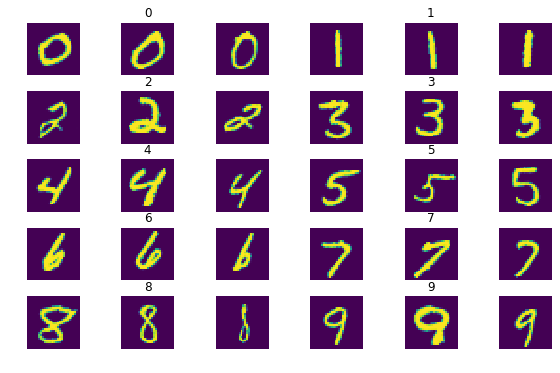

	Epoch: 89, Generator Loss: 0.3704225440820058, Discriminator Loss: [0.07087653 0.        ]


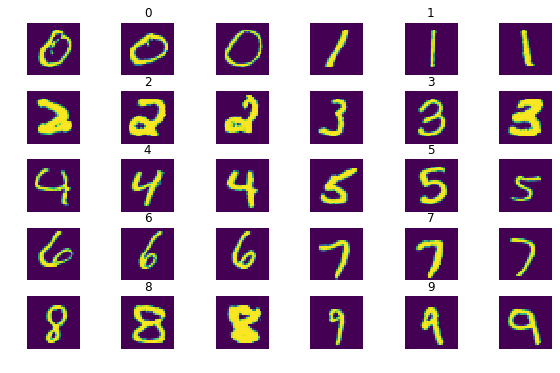

	Epoch: 90, Generator Loss: 0.37281112213929496, Discriminator Loss: [0.0709497 0.       ]


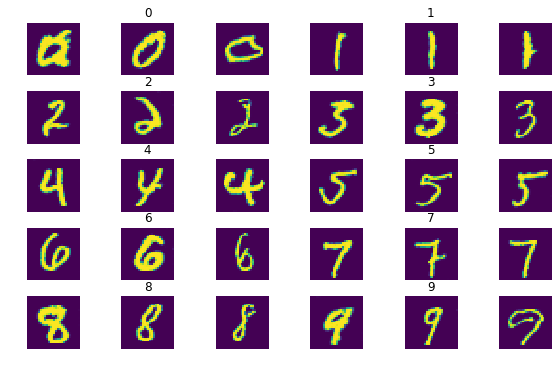

	Epoch: 91, Generator Loss: 0.37419035971164705, Discriminator Loss: [0.07077869 0.        ]


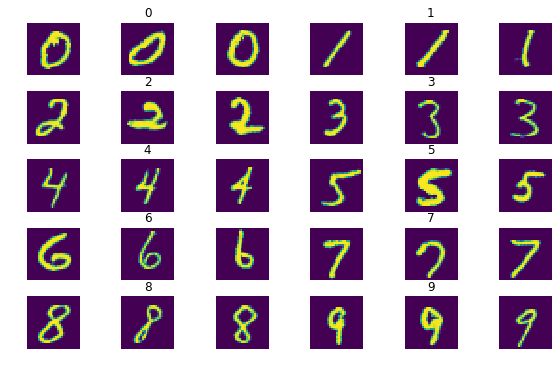

	Epoch: 92, Generator Loss: 0.3676864554484685, Discriminator Loss: [0.07081303 0.        ]


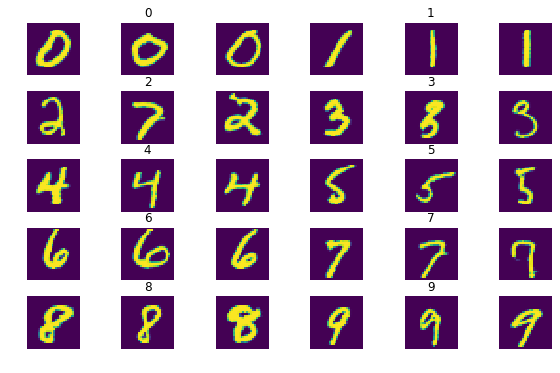

	Epoch: 93, Generator Loss: 0.37048092305660246, Discriminator Loss: [0.07074022 0.        ]


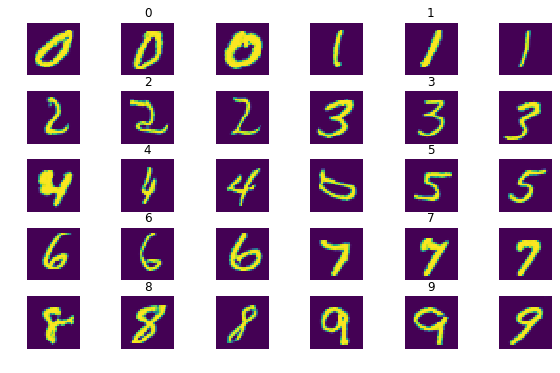

	Epoch: 94, Generator Loss: 0.3757482876380285, Discriminator Loss: [0.07089598 0.        ]


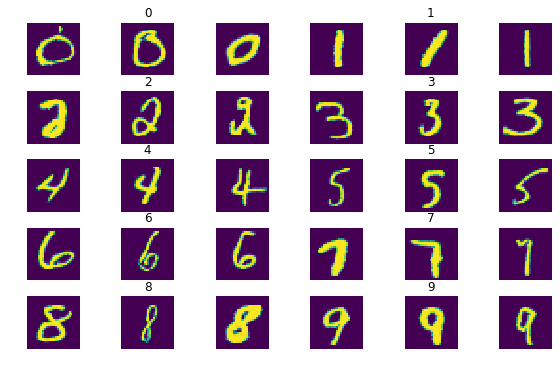

	Epoch: 95, Generator Loss: 0.3727461051940918, Discriminator Loss: [0.06993253 0.        ]


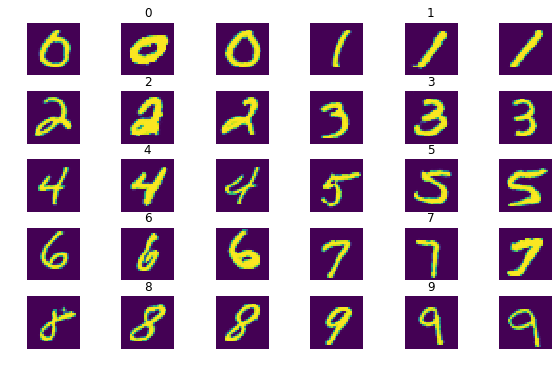

	Epoch: 96, Generator Loss: 0.3777349023024241, Discriminator Loss: [0.06969704 0.        ]


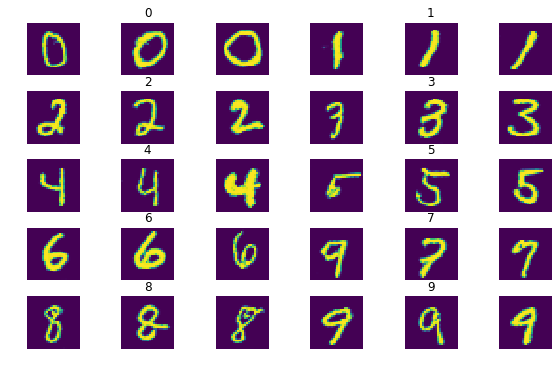

	Epoch: 97, Generator Loss: 0.3844073377052943, Discriminator Loss: [0.0699808 0.       ]


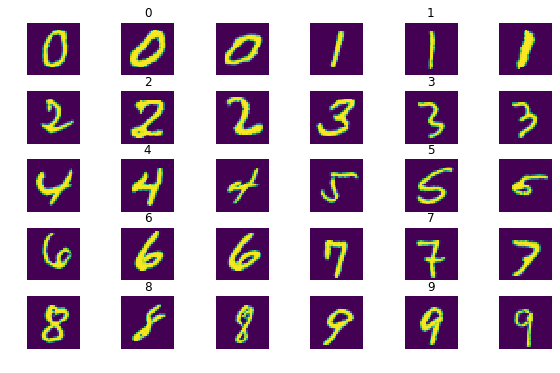

	Epoch: 98, Generator Loss: 0.3756561541557312, Discriminator Loss: [0.07066185 0.        ]


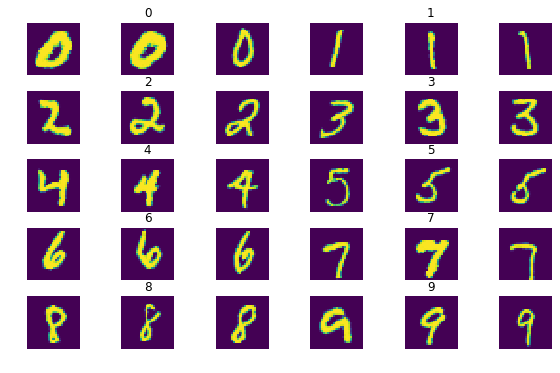

	Epoch: 99, Generator Loss: 0.38144603033860525, Discriminator Loss: [0.06933938 0.        ]


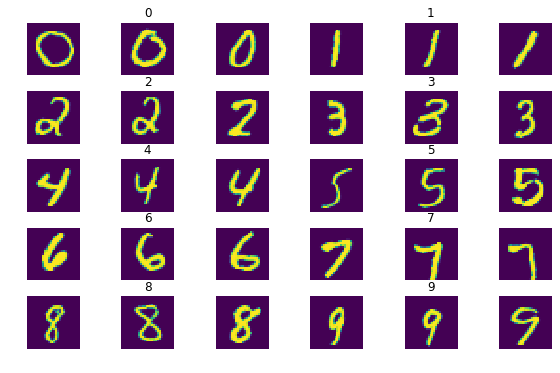

	Epoch: 100, Generator Loss: 0.3736707890033722, Discriminator Loss: [0.06914675 0.        ]


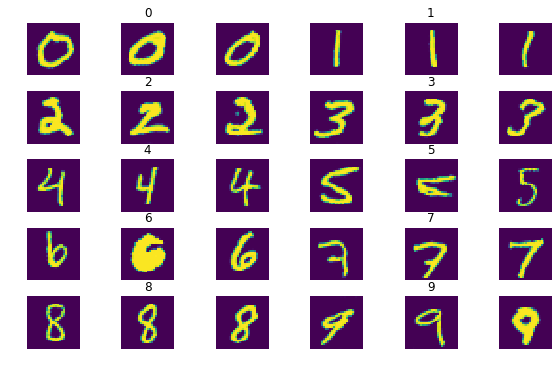

In [81]:
N_EPOCHS = 100 #number of epochs
for epoch in range(N_EPOCHS):
  cum_d_loss = 0.
  cum_g_loss = 0.
  for batch_idx in range(num_batches):
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    generated_images = generator.predict([noise_data, labels])
    noise_prop = 0.05 
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
      break
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_samples("epoch" + str(epoch))


In [82]:
label=one_hot_encode([0]*9)
print(label)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


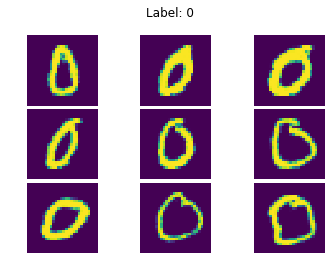

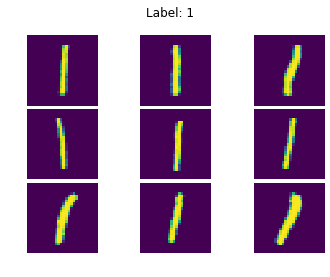

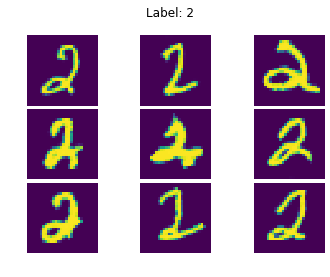

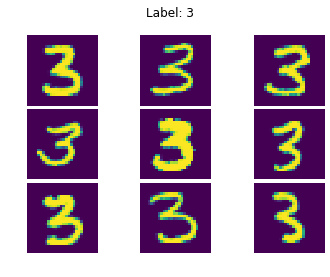

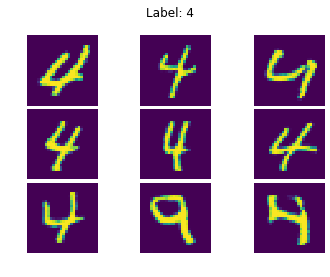

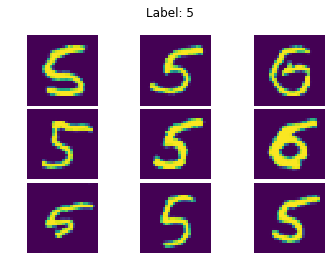

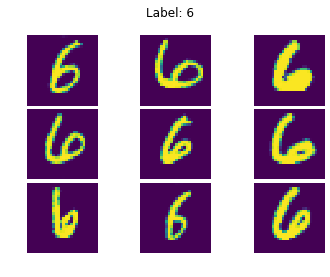

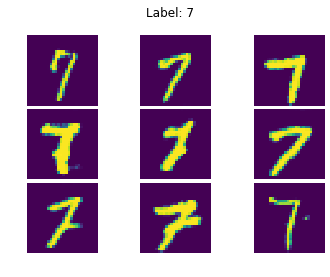

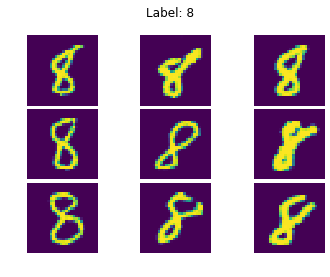

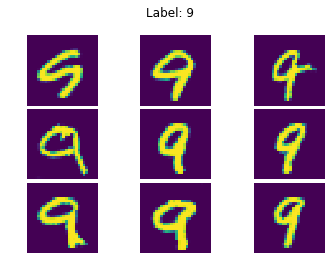

In [83]:
for classlabel in range(10):
  lbls = one_hot_encode([classlabel] * 9)
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict([noise, lbls])
  fig, axs = plt.subplots(3, 3)
  plt.subplots_adjust(hspace=0.05, wspace=0.05)
  count = 0
  for i in range(3):
    for j in range(3):
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      plt.suptitle('Label: ' + str(classlabel))
      count += 1
  plt.show()
  plt.close()